# Flawed steel cased well in a layered space

[Lindsey Heagy](http://github.com/lheagy)

SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
import ipywidgets

import discretize
from discretize import utils
from SimPEG import Utils, Maps
from SimPEG.Survey import Data
from pymatsolver import Pardiso


import casingSimulations as casingSim

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 14

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $5\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In [3]:
simDir = "dc_flaw_w_layer"

In [4]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

model = casingSim.model.FlawedCasingInSingleLayer(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    layer_z = np.r_[-450, -400],  # 50m thick layer
    src_a = np.r_[0., 3*np.pi/2., -1.25],  # put the A electrode just below the surface
    src_b = np.r_[1*casing_l, 3*np.pi/2., -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, 3*np.pi/2., -1.25] 

In [5]:
model.serialize()

{'__class__': 'FlawedCasingInSingleLayer',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'dc_flaw_w_layer',
 'filename': 'ModelParameters.json',
 'flaw_r': [0.0, 0.0],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [0.0, 0.0],
 'layer_z': [-450, -400],
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'mur_flaw': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_flaw': 5500000.0,
 'sigma_inside': 0.1,
 'sigma_layer': 0.01,
 'src_a': [0.045000000000000005, 4.71238898038469, -1.25],
 'src_b': [1000.0, 4.71238898038469, -1.25],
 'surface_z': 0.0,
 'version': '0.0.5'}

In [6]:
experiment = 1  # 1000 m well, break at 500m, compare with short well

In [7]:
copiedmodelparams = {
    key: val for key, val in model.serialize().items() if key in dir(casingSim.model.CasingInSingleLayer) and not key.startswith('_') 
}

In [8]:
background = casingSim.model.CasingInSingleLayer(
    **copiedmodelparams
)

### Set up the models

In [9]:
flaw_depth = 500.

In [10]:
model.flaw_r = np.r_[model.casing_a, model.casing_b]
model.flaw_z = np.r_[-10, 0] - flaw_depth
model.sigma_flaw = model.sigma_back

In [11]:
sigma_layer = [1e-3, 1e-2, 1e-1, 1, 10]

flawed_models = {}
baseline_models = {}

for sig in sigma_layer:
    tmp_flawed = model.copy()
    tmp_flawed.sigma_layer = sig

    tmp_baseline = background.copy()
    tmp_baseline.sigma_layer = sig

    flawed_models['flaw_{}'.format(sig)] = tmp_flawed
    baseline_models['baseline_{}'.format(sig)] = tmp_baseline

In [12]:
baseline_models

{'baseline_0.001': <casingSimulations.model.CasingInSingleLayer at 0x116245a90>,
 'baseline_0.01': <casingSimulations.model.CasingInSingleLayer at 0x116245b00>,
 'baseline_0.1': <casingSimulations.model.CasingInSingleLayer at 0x116245940>,
 'baseline_1': <casingSimulations.model.CasingInSingleLayer at 0x116245f98>,
 'baseline_10': <casingSimulations.model.CasingInSingleLayer at 0x11625d278>}

In [13]:
flawed_models

{'flaw_0.001': <casingSimulations.model.FlawedCasingInSingleLayer at 0x116245a58>,
 'flaw_0.01': <casingSimulations.model.FlawedCasingInSingleLayer at 0x116245ac8>,
 'flaw_0.1': <casingSimulations.model.FlawedCasingInSingleLayer at 0x116245c88>,
 'flaw_1': <casingSimulations.model.FlawedCasingInSingleLayer at 0x116245eb8>,
 'flaw_10': <casingSimulations.model.FlawedCasingInSingleLayer at 0x11625d198>}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [14]:
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(16)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [15]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 50.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


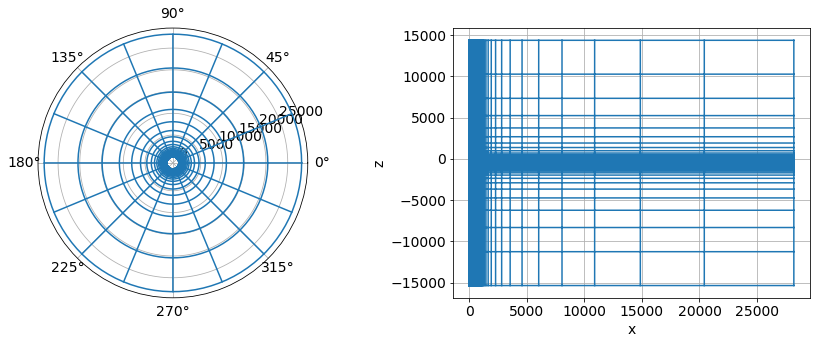

In [16]:
cylMeshGen.mesh.plotGrid()

In [17]:
src_theta = cylMeshGen.hy[0]/2. + np.pi
model.src_a[1] = src_theta
model.src_b[1] = src_theta

(0.0, 3000.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


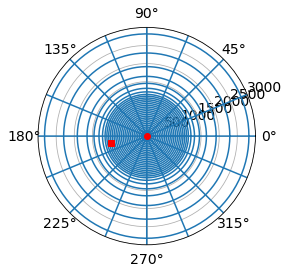

In [18]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [19]:
# put the models in a dictionary for convienence 
modelDict = baseline_models
modelDict.update(flawed_models)
model_names = sorted(baseline_models.keys())
print(model_names)

['baseline_0.001', 'baseline_0.01', 'baseline_0.1', 'baseline_1', 'baseline_10', 'flaw_0.001', 'flaw_0.01', 'flaw_0.1', 'flaw_1', 'flaw_10']


In [20]:
for mod in modelDict.values():
    mod.src_a[1] = src_theta
    mod.src_b[1] = src_theta

In [21]:
# Assign physical properties on the mesh
physpropsDict = dict(
    [
        (name, casingSim.model.PhysicalProperties(cylMeshGen, mod)) 
        for name, mod in modelDict.items()
    ]
)

In [22]:
model_names

['baseline_0.001',
 'baseline_0.01',
 'baseline_0.1',
 'baseline_1',
 'baseline_10',
 'flaw_0.001',
 'flaw_0.01',
 'flaw_0.1',
 'flaw_1',
 'flaw_10']

In [23]:
modelDict[model_names[0]].serialize()

{'__class__': 'CasingInSingleLayer',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'dc_flaw_w_layer',
 'filename': 'ModelParameters.json',
 'layer_z': [-450.0, -400.0],
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'sigma_layer': 0.001,
 'src_a': [0.045000000000000005, 3.3379421944391554, -1.25],
 'src_b': [1000.0, 3.3379421944391554, -1.25],
 'surface_z': 0.0,
 'version': '0.0.5'}

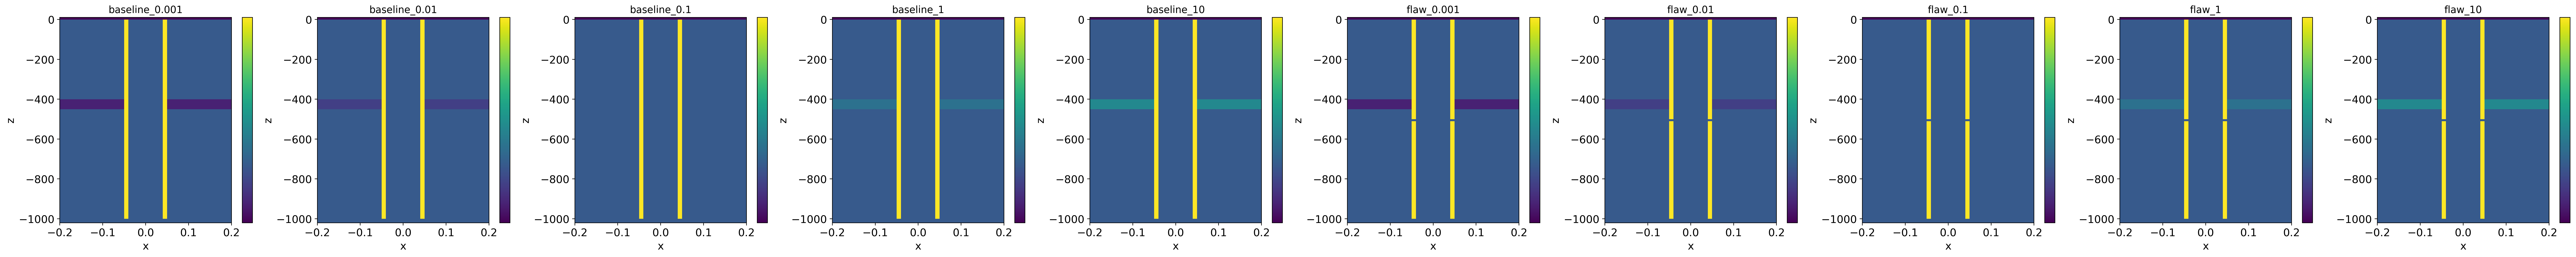

In [24]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l -20, 10]
    

theta_ind = 10

plot_models = model_names

fig, ax = plt.subplots(1, len(plot_models), figsize=(6*len(plot_models), 5), dpi=350)
for a, title in zip(ax, plot_models):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        theta_ind=theta_ind,
        pcolorOpts={'norm':LogNorm()},  # plot on a log-scale
#         clim = np.r_[1e-6, 1e2]
    )
    a.set_title('{}'.format(title), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [25]:
model.src_a, model.src_b

(array([ 0.045     ,  3.33794219, -1.25      ]),
 array([1000.        ,    3.33794219,   -1.25      ]))

In [26]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_locs = [500]

src_b = np.vstack(
    [[loc, model.src_b[1], model.src_b[2]] for loc in src_locs]
)

src_a = np.ones((src_b.shape[0], 1)) * model.src_a

In [27]:
src_b

array([[500.        ,   3.33794219,  -1.25      ]])

## set up a DC simulation

In [28]:
# model_names = ["baseline", "flawed"]

In [29]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=modelDict[key], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [39]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run(save=False)
    print('\n')

--- Running baseline_0.001 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 32.23631000518799


--- Running baseline_0.01 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 35.95601987838745


--- Running baseline_0.1 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 60.69604802131653


--- Running baseline_1 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <cl

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [40]:
def plot_radial_efields(
    ax=None, key="baseline", src_ind=0, xlim=[5., 2000.], theta_ind=1, color_ind=0, 
    label=None, include_baseline=True
):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
    
    if label is None:
        label=key 
        
#     for i, key in enumerate(model_names):
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict['baseline'].survey.srcList[src_ind]
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh, field=np.absolute(f[src,'e']), pltType='semilogy',
        ax=ax[0], theta_ind=theta_ind, xlim=xlim, label=label, color_ind=color_ind
    )
    
    if include_baseline is True: 
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=np.absolute(fieldsDict['baseline'][baseline_src,'e']), pltType='semilogy',
            ax=ax[0], theta_ind=theta_ind, xlim=xlim, label='baseline' if label is None else None, 
            color='k'
        )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
            (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )

    ax[0].set_ylabel('Electric Field (V/m)')
    ax[1].set_ylabel('percent difference')
    
    ax[2].set_ylim([0., 100.])
    ax[0].set_title("{:1.1f}\n{:1.1f}".format(src_locs[src_ind], cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi))
    
#     [a.set_ylim([1e-7, 1e-3]) for a in ax[:2]]
    [a.legend() for a in ax]

interactive(children=(ToggleButtons(description='key', options=('baseline_0.01', 'baseline_0.1', 'baseline_1', 'baseline_10', 'flaw_0.001', 'flaw_0.01', 'flaw_0.1', 'flaw_1', 'flaw_10'), value='baseline_0.01'), IntSlider(value=0, description='src_ind', max=0), IntSlider(value=0, description='theta_ind', max=15), Output()), _dom_classes=('widget-interact',))

<function __main__.<lambda>>

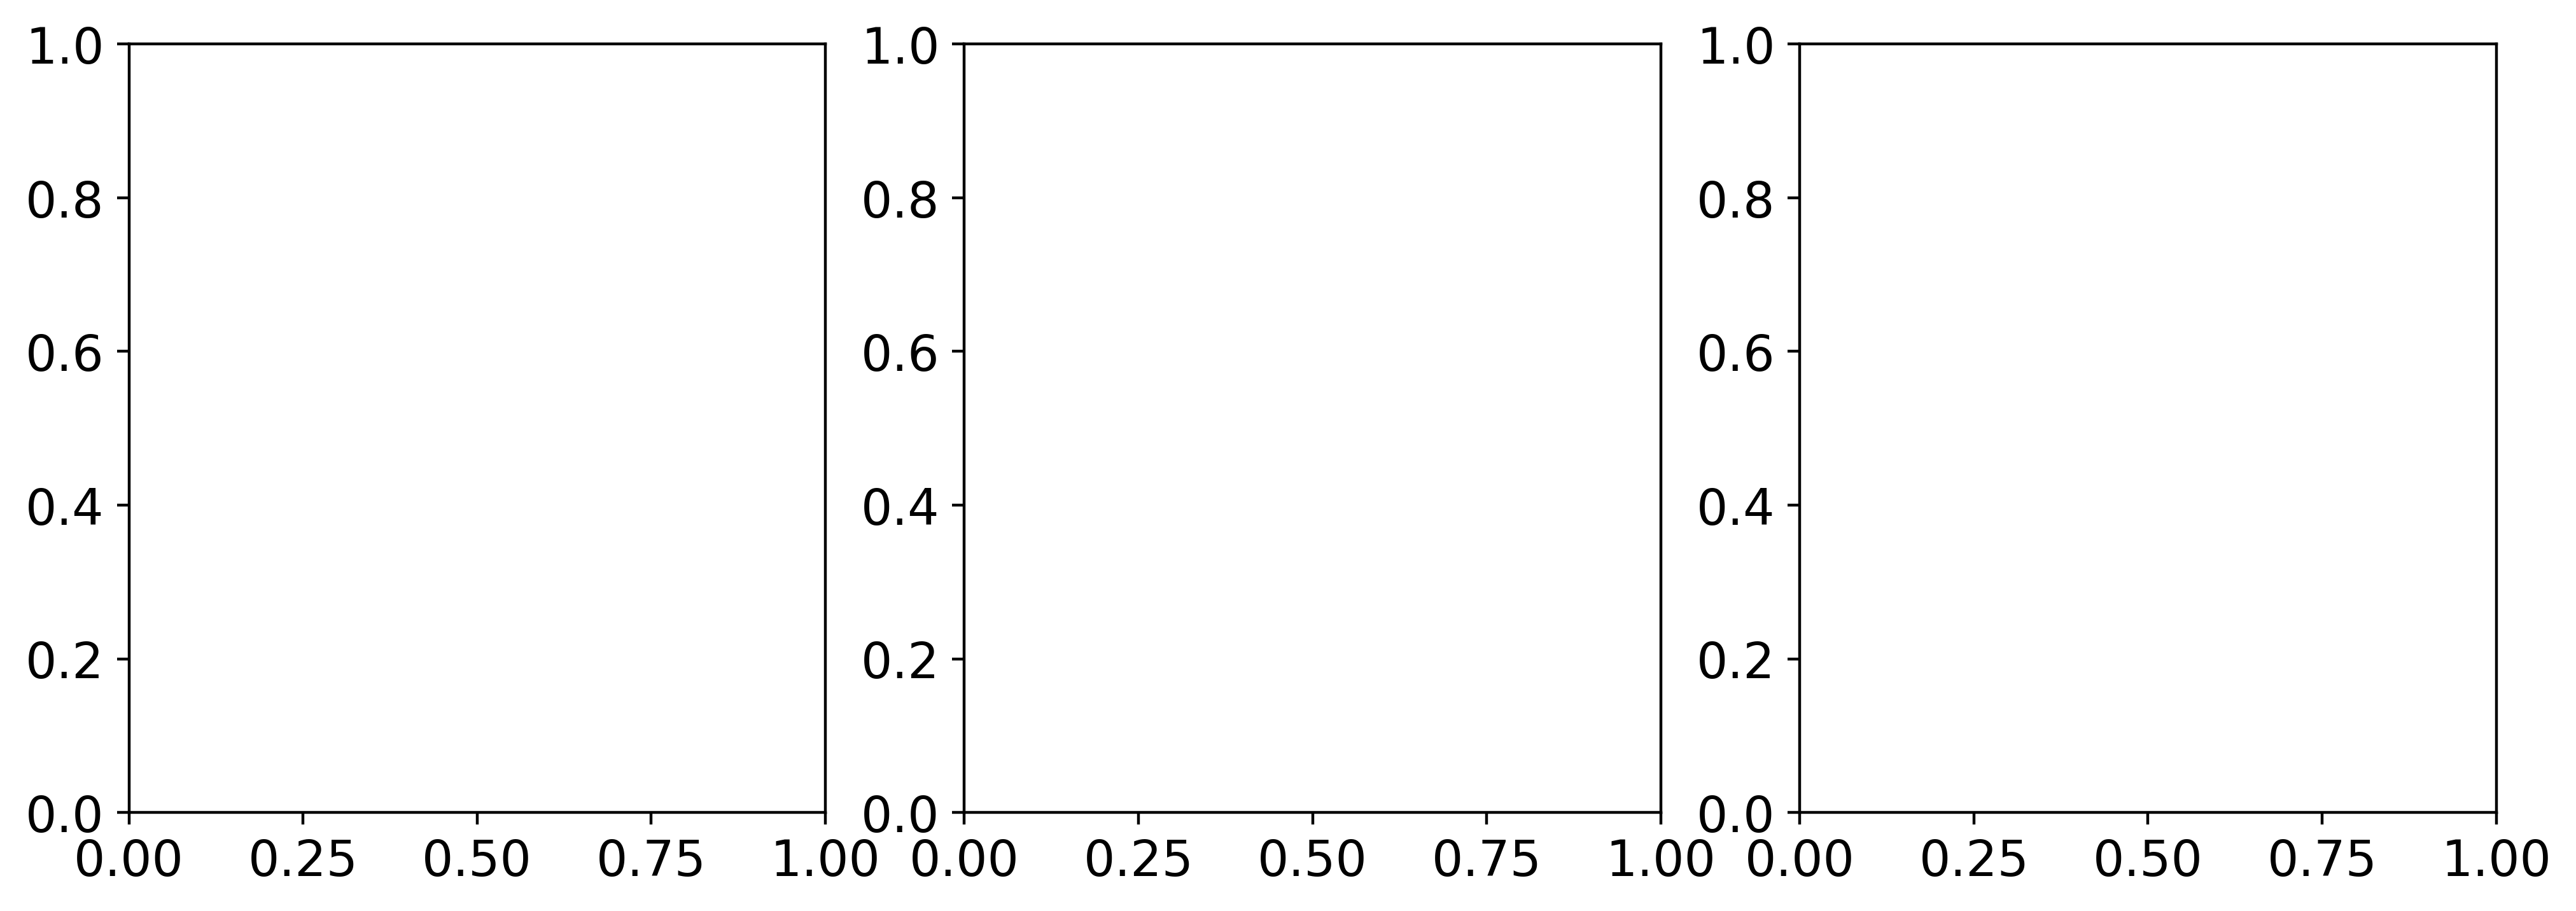

In [41]:
def widget_wrapper(key, src_ind, theta_ind):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    plot_radial_efields(key=key, src_ind=src_ind, theta_ind=theta_ind)
    plt.tight_layout()
    plt.show()
    
ipywidgets.interact(
    lambda key, src_ind, theta_ind: widget_wrapper(key, src_ind, theta_ind),
    key=ipywidgets.ToggleButtons(options=model_names[1:], value=model_names[1]),
    src_ind=ipywidgets.IntSlider(min=0, max=len(src_locs)-1, value=0),
    theta_ind=ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=0)
)

In [33]:
def widget_wrapper2(key, theta_ind):
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=400)
    for src_ind in range(len(src_locs)-1):
        plot_radial_efields(
            key=key, src_ind=src_ind, theta_ind=theta_ind, ax=ax, 
            color_ind=src_ind, label="{:1.1e}".format(src_locs[src_ind]),
            include_baseline=False
        )
    ax[2].set_ylim([0, 200])
    plt.tight_layout()
    plt.show()
    
ipywidgets.interact(
    lambda key, theta_ind: widget_wrapper2(key, theta_ind),
    key=ipywidgets.ToggleButtons(options=model_names[1:], value=model_names[1]),
    src_ind=ipywidgets.IntSlider(min=0, max=len(src_locs)-1, value=0),
    theta_ind=ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=3)
)
# plot_radial_efields(ax=ax, src_ind=0)

interactive(children=(ToggleButtons(description='key', options=('baseline_0.01', 'baseline_0.1', 'baseline_1', 'baseline_10', 'flaw_0.001', 'flaw_0.01', 'flaw_0.1', 'flaw_1', 'flaw_10'), value='baseline_0.01'), IntSlider(value=3, description='theta_ind', max=15), Output()), _dom_classes=('widget-interact',))

<function __main__.<lambda>>

In [42]:
from SimPEG import DC

In [43]:
rx_r = cylMeshGen.mesh.vectorCCx[(cylMeshGen.mesh.vectorCCx > 2) & (cylMeshGen.mesh.vectorCCx < 2600)]
rx_y = np.r_[cylMeshGen.mesh.vectorCCy[3]]
rx_z = np.r_[-1.25]
rx = DC.Rx.Pole(utils.ndgrid(rx_r, rx_y, rx_z))

In [44]:
for m in model_names:
    srcList=simDict[m].survey.srcList
    for src in srcList: 
        src.rxList = [rx]

In [45]:
%%time

data_dict = {}
for key in model_names:
    model = physpropsDict[key].model
    simDict[key].prob.model = model
    data_dict[key] = Data(simDict[key].survey, simDict[key].survey.dpred(model, f=fieldsDict[key]))

CPU times: user 621 ms, sys: 617 ms, total: 1.24 s
Wall time: 1.9 s


In [46]:
for key in model_names:
    simDict[key].survey.dobs = data_dict[key].tovec()

In [47]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# key=model_names[1]
# DC.Utils.plot_pseudoSection(
#     simDict[key].survey, survey_type='dipole-pole', data_type='volt', 
#     dobs=(data_dict[key].tovec() - data_dict['baseline'].tovec()),
#     scale='linear', ax=ax, clim=np.r_[0., 1.]*1e-2
# )

In [48]:
simDict

{'baseline_0.001': <casingSimulations.run.SimulationDC at 0x11b48f828>,
 'baseline_0.01': <casingSimulations.run.SimulationDC at 0x11b189400>,
 'baseline_0.1': <casingSimulations.run.SimulationDC at 0x1825e26550>,
 'baseline_1': <casingSimulations.run.SimulationDC at 0x1825e0c4e0>,
 'baseline_10': <casingSimulations.run.SimulationDC at 0x11b672588>,
 'flaw_0.001': <casingSimulations.run.SimulationDC at 0x182711db38>,
 'flaw_0.01': <casingSimulations.run.SimulationDC at 0x18276790b8>,
 'flaw_0.1': <casingSimulations.run.SimulationDC at 0x18276793c8>,
 'flaw_1': <casingSimulations.run.SimulationDC at 0x18271393c8>,
 'flaw_10': <casingSimulations.run.SimulationDC at 0x11b449860>}

In [49]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names
)

In [50]:
viewer.widget_cross_section(defaults={"min_depth":0, "max_depth":casing_l*1.25})

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=0.0, description='min_depth'), FloatText(value=1250.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('baseline_0.001', 'baseline_0.01', 'baseline_0.1', 'baseline_1', 'baseline_10', 'flaw_0.001', 'flaw_0.01', 'flaw_0.1', 'flaw_1', 'flaw_10', 'all'), value='baseline_0.001'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge'), value='sigma'), IntSlider(value=0, description='theta_ind', max=15), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [51]:
viewer.widget_depth_slice(defaults={"z_ind": 426, 'view': 'e', 'max_r':500})

interactive(children=(FloatText(value=500.0, description='max_r'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('baseline_0.001', 'baseline_0.01', 'baseline_0.1', 'baseline_1', 'baseline_10', 'flaw_0.001', 'flaw_0.01', 'flaw_0.1', 'flaw_1', 'flaw_10', 'all'), value='baseline_0.001'), ToggleButtons(description='view', index=1, options=('sigma', 'e', 'j', 'phi', 'charge'), value='e'), IntSlider(value=426, description='z_ind', max=453), Checkbox(value=False, description='use_aspect'), Checkbox(value=False, description='rotate'), IntSlider(value=10, description='k', max=50), FloatText(value=0.0, description='theta_shift'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [52]:
mesh = cylMeshGen.mesh

In [53]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="baseline"
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    
    if secondary is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        plotme = plotme - f_prim[src_prim, 'charge']
    z_charges, charges = casingSim.casing_charges(plotme, mesh, mod)
    ax.plot(
        -z_charges, charges, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle
    )
        

In [54]:
len(srcList)

1

In [55]:
from string import ascii_lowercase

KeyError: 'baseline'

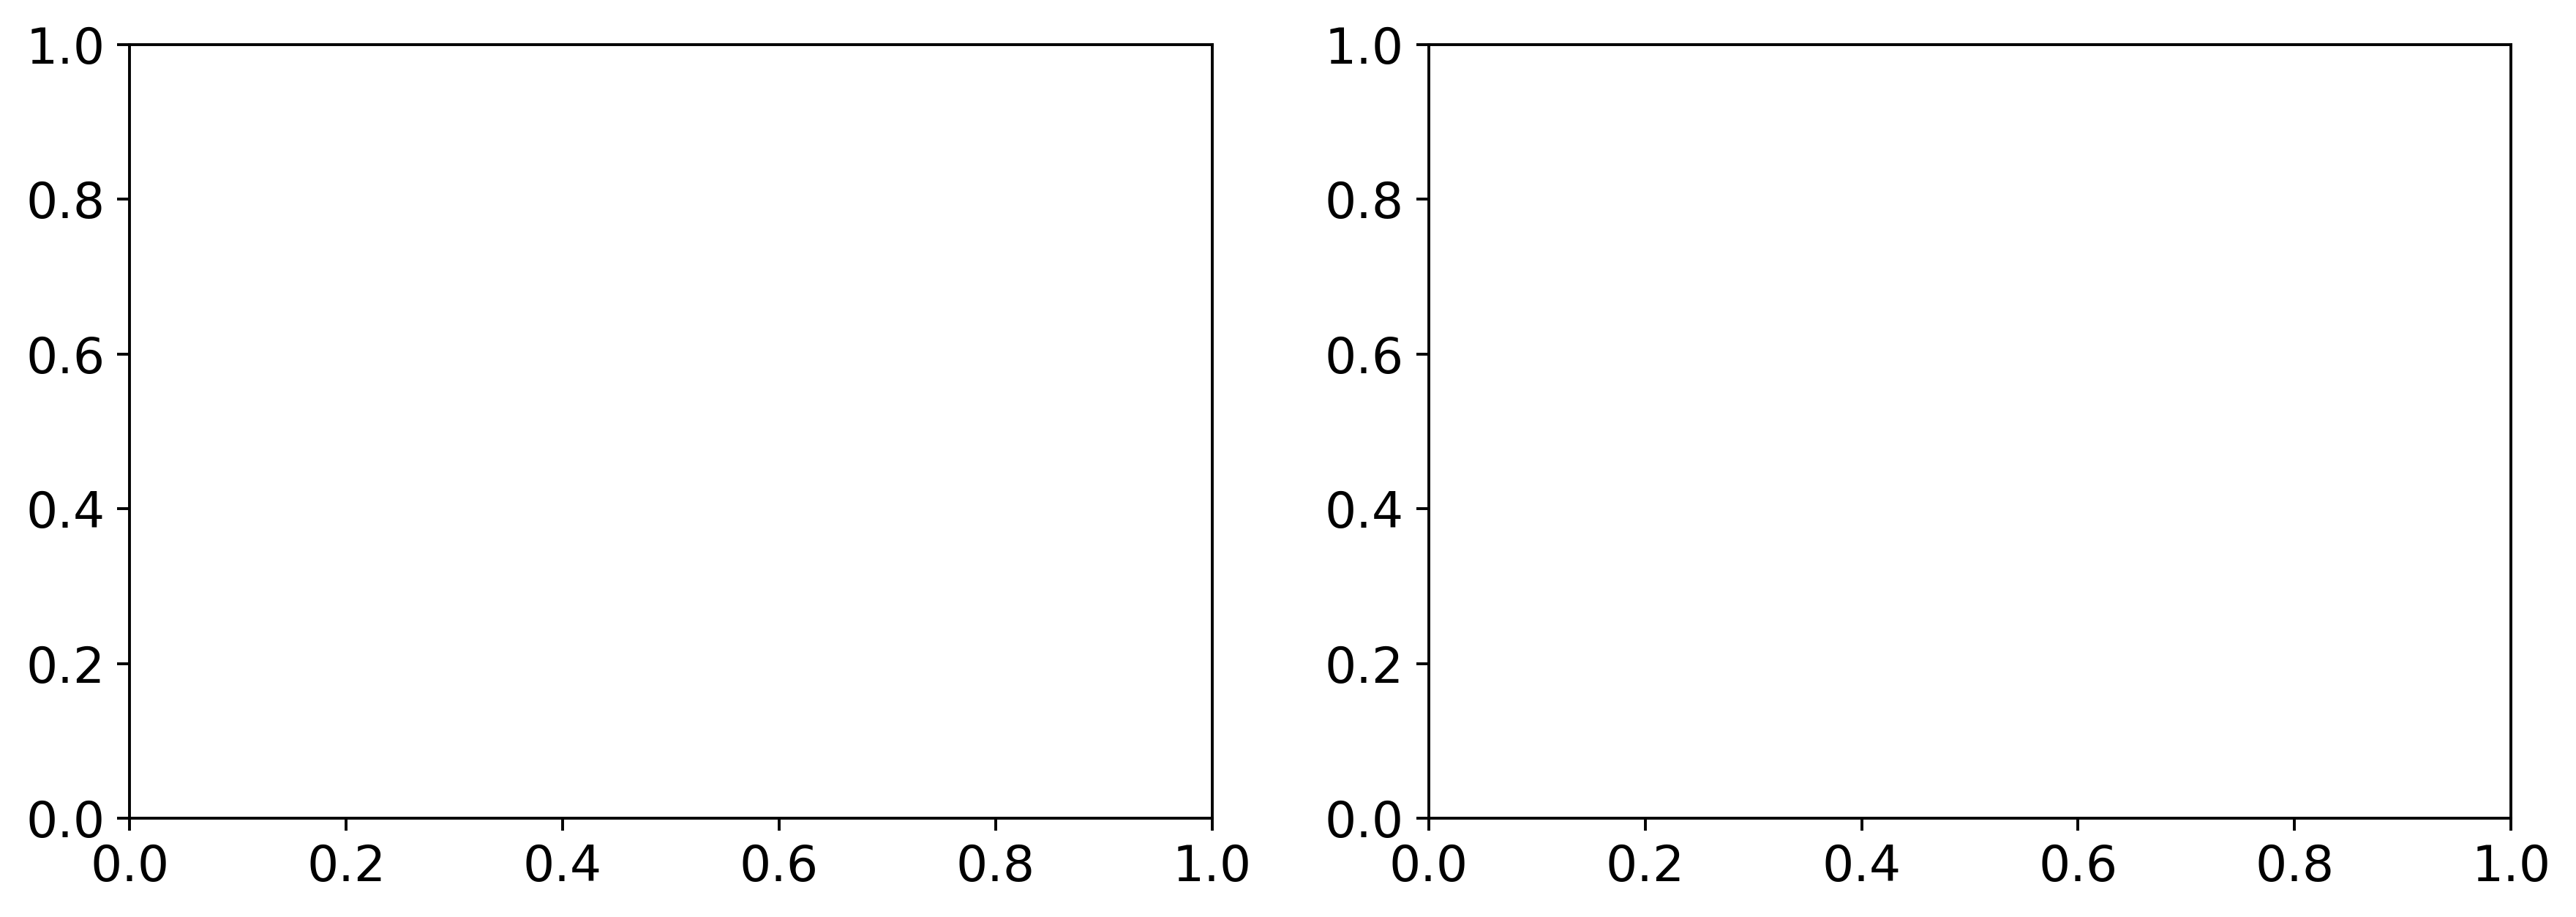

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi = 350)

for i, key in enumerate(['baseline', 'flawed', 'short']):
    plot_charge(ax=ax[0], key=key, color_ind=i, src_ind=len(srcList)-1, label=key if key != 'baseline' else 'intact')
    if key != primary_key:
        plot_charge(ax=ax[1], key=key, color_ind=i, src_ind=len(srcList)-1, label=key, secondary=True)

for i, a in enumerate(ax):
    a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge (C)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)

In [57]:
conductivities = sorted(set([float(m.split("_")[-1]) for m in model_names]))
conductivities

[0.001, 0.01, 0.1, 1.0, 10.0]

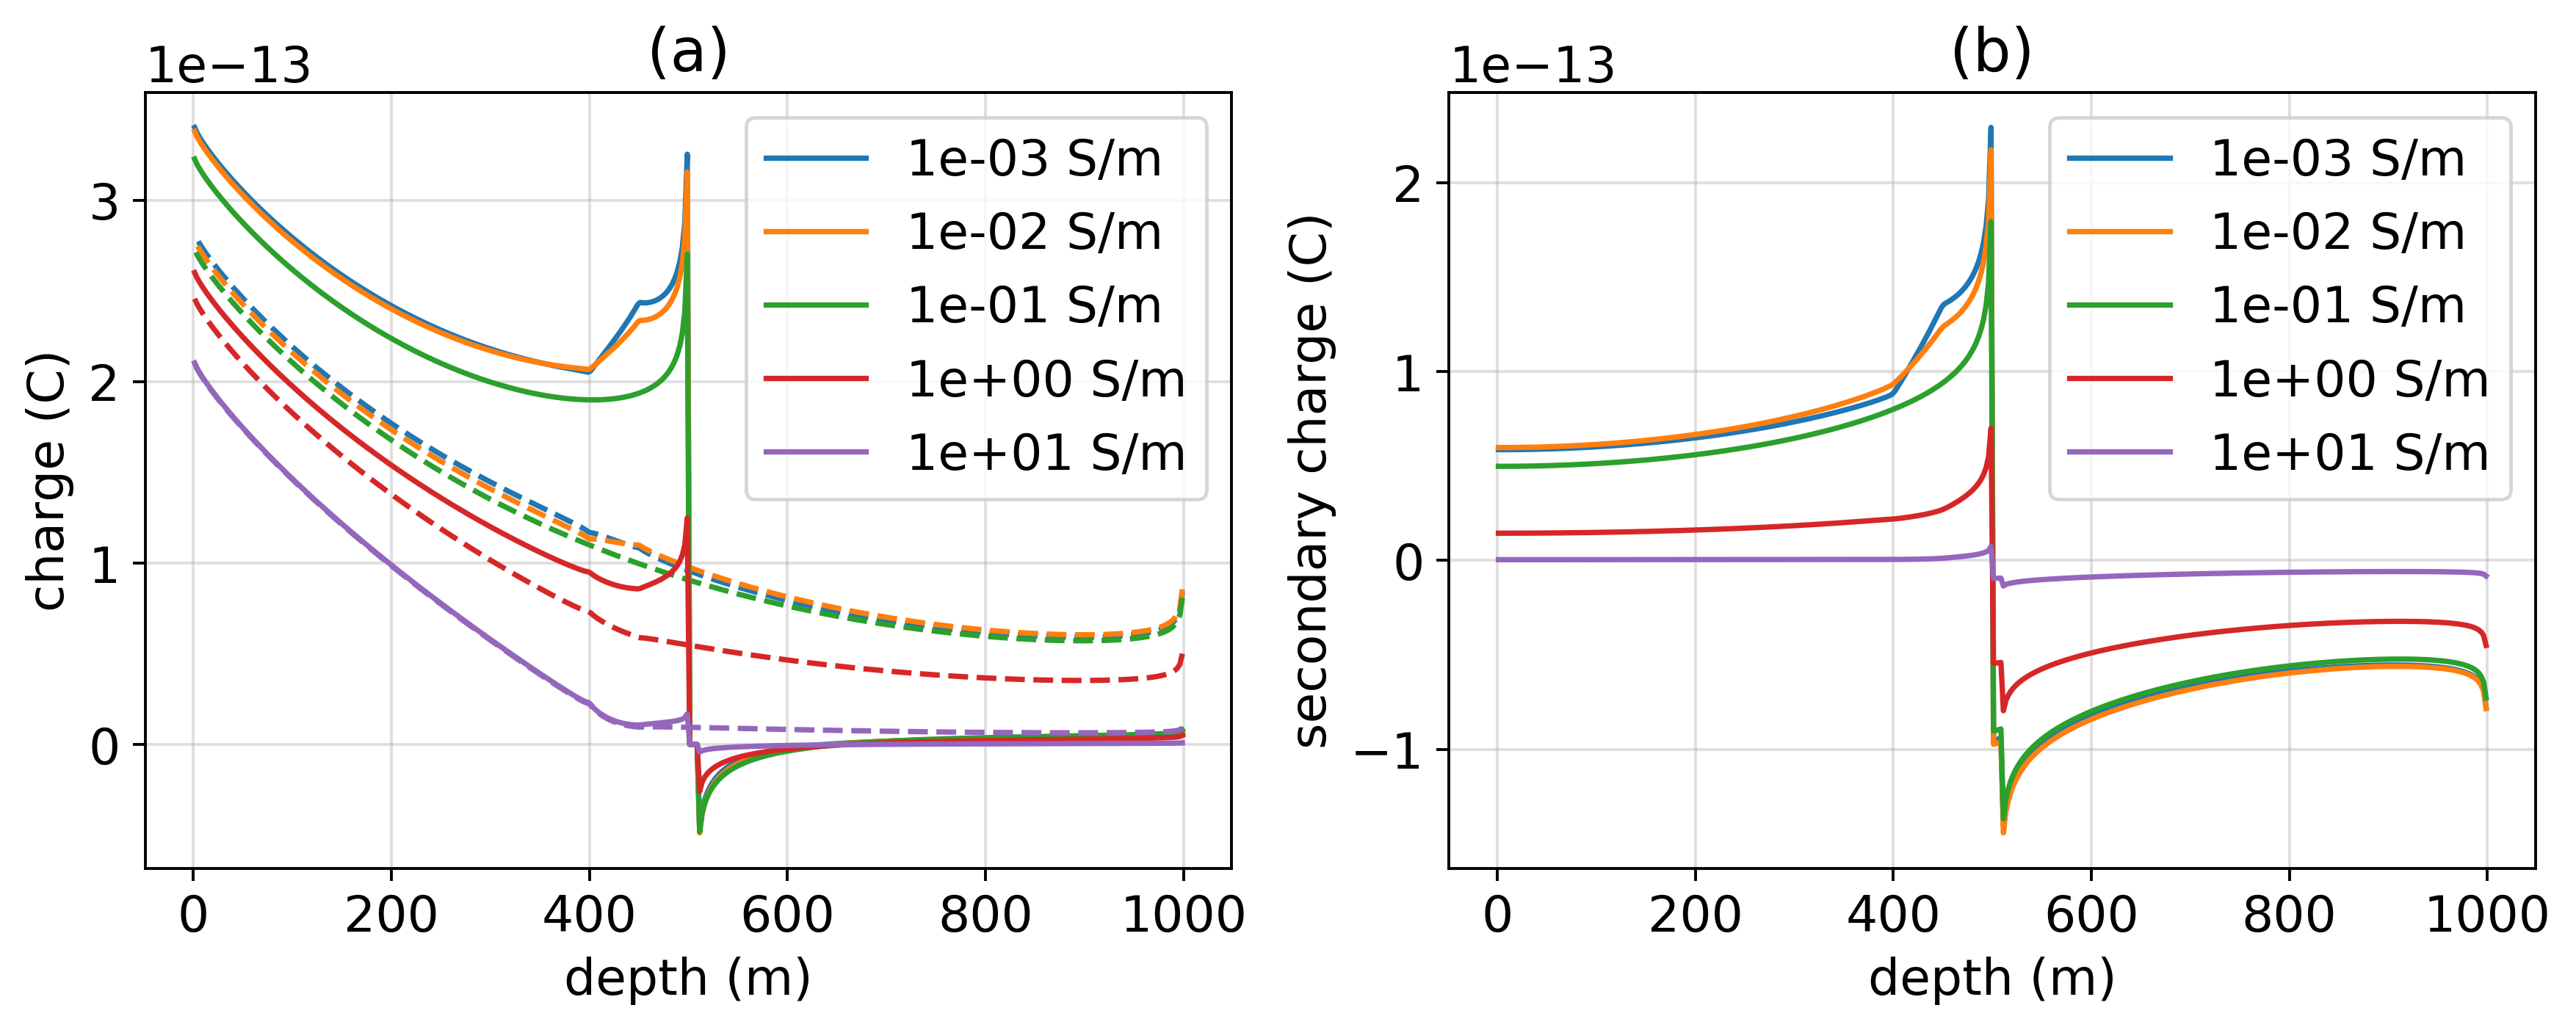

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi = 350)

for i, sigma in enumerate(conductivities):
    key = "flaw_{}".format(sigma if sigma < 1 else int(sigma))
    baseline_key = "baseline_{}".format(sigma if sigma < 1 else int(sigma))
    label = "{:1.0e} S/m".format(sigma)
    # total
    plot_charge(
        ax=ax[0], key=baseline_key, color_ind=i, 
        src_ind=len(srcList)-1, secondary=False,
        linestyle='--'
    )
    plot_charge(
        ax=ax[0], key=key, color_ind=i, 
        src_ind=len(srcList)-1, label=label, secondary=False
    )
    
    # secondary 
    plot_charge(
        ax=ax[1], key=key, color_ind=i, 
        src_ind=len(srcList)-1, secondary=True,
        primary_key=baseline_key, label=label
    )

for i, a in enumerate(ax):
    a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge (C)' if i == 0 else 'secondary charge (C)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)

fig.savefig('casing_charge_layer', dpi=350, bbox_inches="tight")

In [59]:
from string import ascii_lowercase

In [60]:
from matplotlib import rcParams, ticker
rcParams['font.size'] = 12

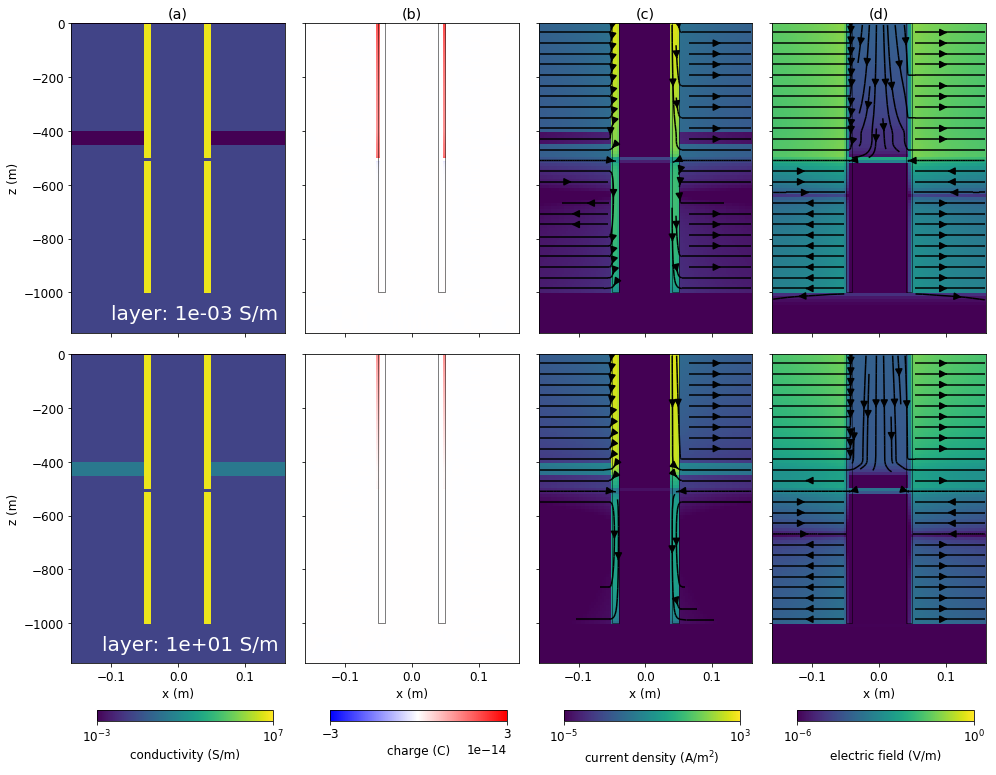

In [61]:
fig, ax = plt.subplots(2, 4, figsize=(4*3.5, 2*5))
fig.subplots_adjust(bottom=0.1)

key_top = "flaw_0.001"
key_bottom = "flaw_10"
src_ind = 0

max_r = 0.16
min_depth = 0
max_depth = 1150

zlim = np.r_[-max_depth, -min_depth]
xlim = max_r * np.r_[-1., 1.]
stream_opts = {"color":"k", "arrowsize":1.5}

for i, key in enumerate([key_top, key_bottom]):
    
    sigma_out = viewer.plot_cross_section(
        ax=ax[i][0], 
        clim=np.r_[1e-3, 1e7],
        xlim=xlim, 
        zlim=zlim,
        view='sigma', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=False,
        stream_opts=stream_opts
    )
    ax[i][0].text(
        max_r - 0.01, -max_depth+50, 
        "layer: {:1.0e} S/m".format(float(key.split("_")[-1])), 
        color='w', fontsize=20, horizontalalignment="right"
    )
    
    charge_out = viewer.plot_cross_section(
        ax=ax[i][1], 
        clim=3e-14 * np.r_[-1, 1],
        xlim=xlim, 
        zlim=zlim,
        view='charge', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        stream_opts=stream_opts
    )
    
    
    currents_out = viewer.plot_cross_section(
        ax=ax[i][2], 
        clim= np.r_[1e-5, 1e3],
        xlim=xlim, 
        zlim=zlim,
        view='j', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    efields_out = viewer.plot_cross_section(
        ax=ax[i][3], 
        clim= np.r_[1e-6, 1],
        xlim=xlim, 
        zlim=zlim,
        view='e', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    
    if i == 0: 
        for j, a in enumerate(ax[i]):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            a.set_ylabel('z (m)')
            a.set_title('({})'.format(ascii_lowercase[j]))
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    else:
        for j, a in enumerate(ax[i]):
            a.set_xlabel('x (m)')
            a.set_title('')
            a.set_ylabel('z (m)')
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    
# cbar_ax = fig.add_axes([0.25, -0.01, 0.11, 0.01])
# cb_charge = fig.colorbar(charge_out[0], ax=cbar_ax, orientation='horizontal')
        
plt.tight_layout()

for i, out, label in zip(
    np.arange(4), 
    [sigma_out, charge_out, currents_out, efields_out],
    ['conductivity (S/m)', 'charge (C)', 'current density (A/m$^2$)', 'electric field (V/m)'],
#     [None, None, 'min', 'min']
):
    x = ax[1][i].figbox.corners()[0, 0]
    cbar_ax = fig.add_axes([x+0.025, -0.01, 0.175, 0.015])
    cb = fig.colorbar(
        out[0], cbar_ax, orientation="horizontal"
    )
    cb.set_label(label)
    cb.set_ticks([cb.vmin, cb.vmax])
    cb.update_ticks()

plt.show() 

fig.savefig('integrity_layer_physics', bbox_inches="tight")

In [62]:
cylMeshGen.mesh.hy[0]/2.

0.19634954084936207

In [63]:
from matplotlib import gridspec

NameError: name 'top_key' is not defined

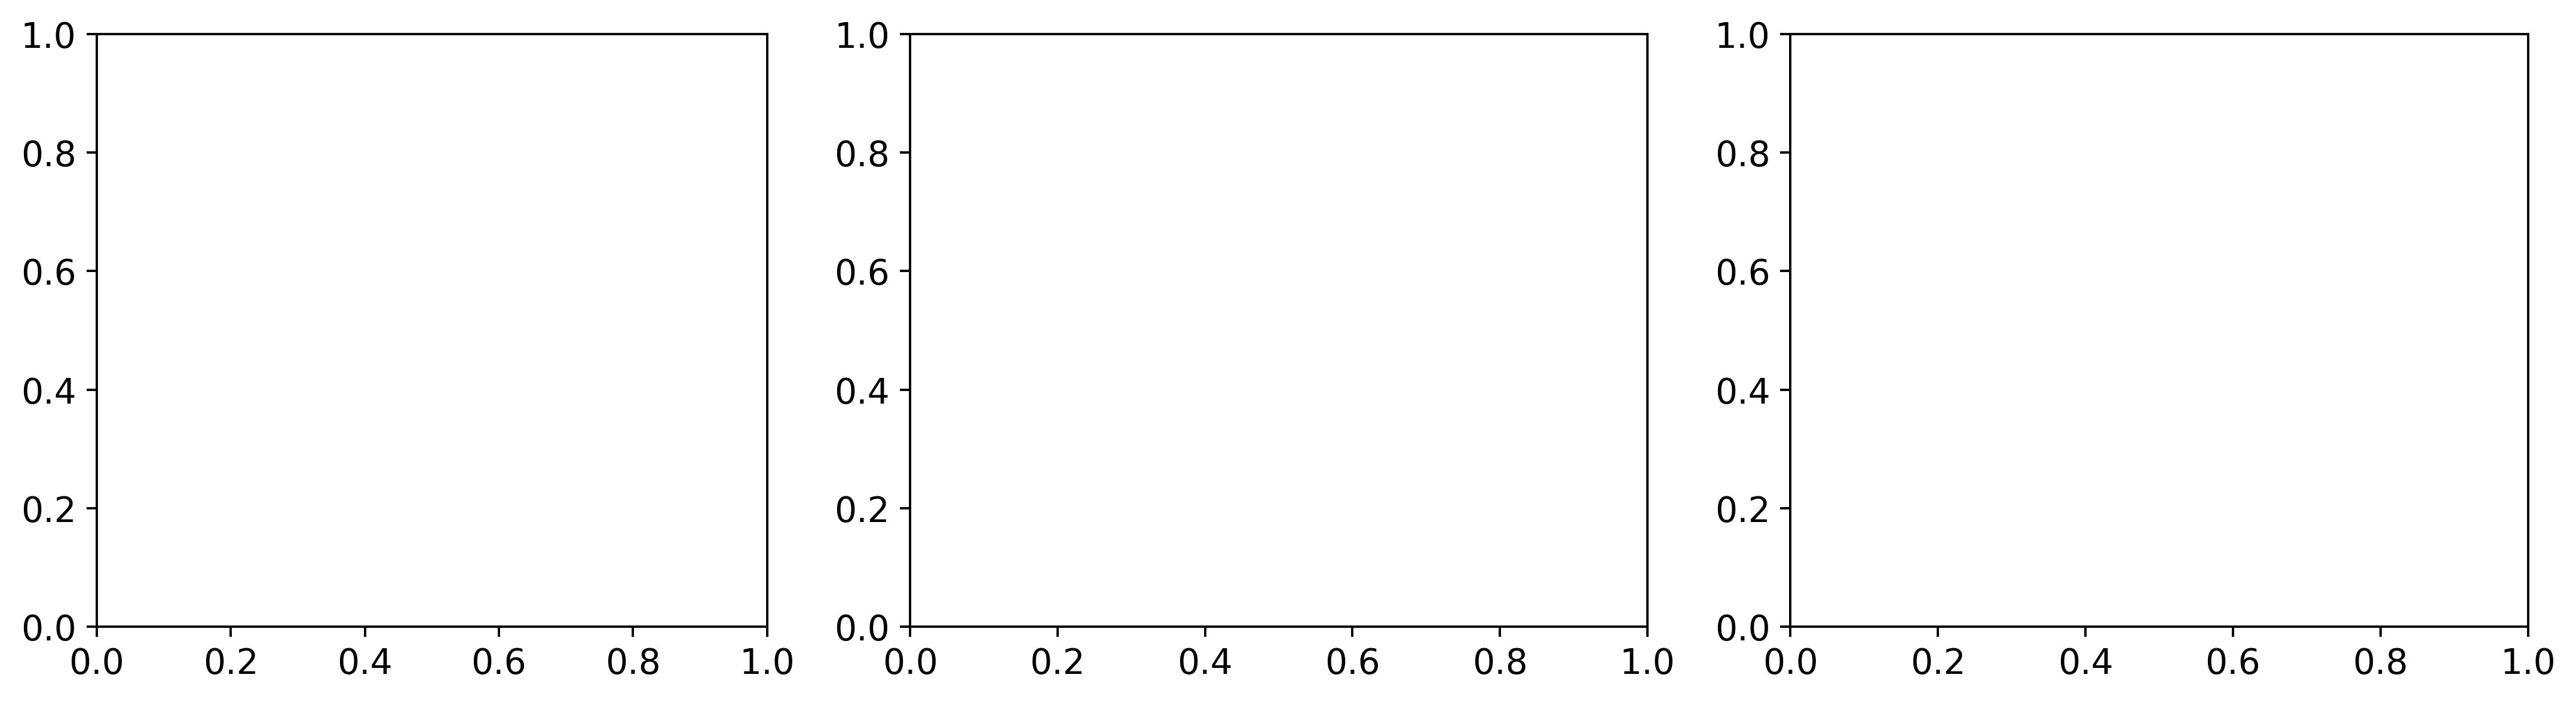

In [64]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 3.5), dpi = 350)

fig = plt.figure(figsize=(15, 3.75), dpi=350) 

key_top = "flawed_0.01"
key_bottom = "flawed_1"
src_ind = 0
# fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1.1, 1.1]) 
ax = [plt.subplot(gs[i]) for i in range(3)]

out = viewer.plot_depth_slice(
    ax=ax[0], model_key=top_key,
    z_ind=426, view='e', xlim=500*np.r_[-1, 1], ylim=500*np.r_[-1, 1], use_aspect=True, 
    stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
    src_ind=src_ind, k=10,
)
ax[0].plot([0, 0], [0, 500], 'w:')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
ax[0].set_title('(a)')
cb = out[-1]
cb.set_label("electric field (V/m)")


theta_ind = 4
f = fieldsDict[key]
xlim = np.r_[10., 1500.]
src_start = 3

for src_ind in np.arange(src_start, len(src_locs)):
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict["baseline"].survey.srcList[src_ind]
    label="{:1.0f}m".format(src_locs[src_ind])

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=src_ind - src_start
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
            (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=src_ind - src_start
    )

ax[1].set_ylabel("secondary electric field (V/m)")
ax[2].set_ylabel("percentage of primary (%)")

ax[1].set_title("(b)")
ax[2].set_title("(c)")

[a.legend() for a in ax[1:]]
    

ax[1].set_ylim([1e-7, 6e-4])
ax[2].set_ylim([0, 250])
plt.tight_layout()
    
fig.savefig('integrity_survey_design', bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=350) 
key = "flawed"
src_inds = [4, 5, 6] 
fig.subplots_adjust(bottom=0.8)
max_r = 1000
for i, a, title in zip(src_inds, ax, ["(a)", "(b)", "(c)"]):

    out = viewer.plot_depth_slice(
        ax=a, model_key=key, prim_sec="primary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=i, k=10, clim = [6e-7, 1e-3], show_cb = False
    )
    a.plot([0, 0], [0, max_r], 'w:')
    a.plot(0, 0, 'ro')
    a.plot(-src_locs[i], 0, 'ro')
    a.set_xlabel('x (m)')
    a.set_ylabel('y (m)')
    a.set_title(title)

for a in ax[1:]:
    a.set_ylabel('')
    a.set_yticklabels(['']*len(a.get_yticklabels()))

cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal') 
cb.set_label("electric field (V/m)")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=350) 
key = "flawed"
src_inds = [4, 5, 6] 
fig.subplots_adjust(bottom=0.8)
max_r = 1000
for i, a, title in zip(src_inds, ax, ["(a)", "(b)", "(c)"]):

    out = viewer.plot_depth_slice(
        ax=a, model_key=key, prim_sec="total",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=i, k=10, clim = [6e-7, 1e-3], show_cb = False
    )
    a.plot([0, 0], [0, max_r], 'w:')
    a.plot(0, 0, 'ro')
    a.plot(-src_locs[i], 0, 'ro')
    a.set_xlabel('x (m)')
    a.set_ylabel('y (m)')
    a.set_title(title)

for a in ax[1:]:
    a.set_ylabel('')
    a.set_yticklabels(['']*len(a.get_yticklabels()))

cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal') 
cb.set_label("electric field (V/m)")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=350) 
key = "flawed"
src_inds = [4, 5, 6] 
fig.subplots_adjust(bottom=0.8)
max_r = 1000
for i, a, title in zip(src_inds, ax, ["(a)", "(b)", "(c)"]):

    out = viewer.plot_depth_slice(
        ax=a, model_key=key, prim_sec="secondary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=i, k=10, clim = [6e-7, 1e-3], show_cb = False
    )
    a.plot([0, 0], [0, max_r], 'w:')
    a.plot(0, 0, 'ro')
    a.plot(-src_locs[i], 0, 'ro')
    a.set_xlabel('x (m)')
    a.set_ylabel('y (m)')
    a.set_title(title)

for a in ax[1:]:
    a.set_ylabel('')
    a.set_yticklabels(['']*len(a.get_yticklabels()))

cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal') 
cb.set_label("electric field (V/m)")

plt.tight_layout()

In [ ]:
src_inds = [4, 5, 6, 7]
fig, ax = plt.subplots(1, 3, figsize=(5*len(src_inds, 4), dpi=350) 
key = "flawed"
 
fig.subplots_adjust(bottom=0.8)
max_r = 1000
for i, a, title in zip(src_inds, ax, ["(a)", "(b)", "(c)"]):

    out = viewer.plot_depth_slice(
        ax=a, model_key=key, prim_sec="percent",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=i, k=10, clim = [25, 100], show_cb = False
    )
    a.plot([0, 0], [0, max_r], 'w:')
    a.plot(0, 0, 'ro')
    a.plot(-src_locs[i], 0, 'ro')
    a.set_xlabel('x (m)')
    a.set_ylabel('y (m)')
    a.set_title(title)

for a in ax[1:]:
    a.set_ylabel('')
    a.set_yticklabels(['']*len(a.get_yticklabels()))

cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal') 
cb.set_label("percentage of primary (%)")

plt.tight_layout()

In [ ]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [ ]:
model_names

In [ ]:
src_inds = [4, 5, 6, 8] 
fig, ax = plt.subplots(3, len(src_inds), figsize=(5*len(src_inds), 12)) #, dpi=300) 

if experiment == 1:
    key = "flawed"
elif experiment == 2:
    key = "flaw_500"
    
# fig.subplots_adjust(bottom=0.8)
max_r = 1250

for i, src_ind in enumerate(src_inds):
    
    out_primary = viewer.plot_depth_slice(
        ax=ax[0, i], model_key=key, prim_sec="primary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = [3e-7, 3e-4], show_cb = True if i == len(src_inds) -1 else False
    )
    
    out_secondary = viewer.plot_depth_slice(
        ax=ax[1, i], model_key=key, prim_sec="secondary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = [3e-7, 3e-4], show_cb = True if i == len(src_inds) -1 else False
    )
    
    
    out_percent = viewer.plot_depth_slice(
        ax=ax[2, i], model_key=key, prim_sec="percent",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = [25, 100], show_cb = True if i == len(src_inds) -1 else False
    )
    
    if i == len(src_inds) - 1:
        out_primary[-1].set_label('primary electric field (V/m)')
        out_secondary[-1].set_label('secondary electric field (V/m)')
        out_percent[-1].set_label('secondary electric field (%)')

    
    for j, a in enumerate(ax[:, i]):
#         a.plot([0, 0], [0, max_r], 'w:')
        a.plot(0, 0, 'ro')
        a.plot(-src_locs[src_ind], 0, 'ro')
        a.set_xlabel('x (m)')
        a.set_ylabel('y (m)')
        
        # titles
        a.set_title("({})".format(ascii_lowercase[i]) if j == 0 else "")
        
        if i > 0:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
        
        if j < 2:
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))
    
    
        
        
        
# for a in ax[1:]:
#     a.set_ylabel('')
#     a.set_yticklabels(['']*len(a.get_yticklabels()))

# cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
# cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal') 
# cb.set_label("electric field (V/m)")

plt.tight_layout()

fig.savefig('integrity_e_fields', dpi=350)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8)) #, dpi=350)
ax = ax.flatten()
src_start=0
theta_ind=4
key = "flaw_900"
xlim = [10., 1500.]
f = fieldsDict[key]
theta_ind = 4

for i, src_ind in enumerate(np.arange(src_start, len(src_locs))):
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict["baseline"].survey.srcList[src_ind]
    label="{:1.0f}m".format(src_locs[src_ind])

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=i
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(fieldsDict['baseline'][baseline_src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=i, linestyle="--"
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[2], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=i
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
            (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[3], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=i
    )

ax[0].set_ylim([1e-7, 1e-3])
ax[1].set_ylim([1e-7, 1e-3])
ax[3].set_ylim([0, 250])
[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax)]
[a.legend() for a in ax]
plt.tight_layout()


In [ ]:
model_names

In [ ]:
src_locs

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (6.5, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 5
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 200]
theta_ind = 4

noise_floor = 1e-7
min_percent = 25

unit = " m" if experiment == 1 else " S/m"

for i, key in enumerate(['baseline'] + model_names[2:]): 
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict["baseline"].survey.srcList[src_ind]
    label="{}".format(key.split("_")[-1] + unit if key != "baseline" else key)

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=i-1 if i !=0 else None, color='k' if i == 0 else None
    )
    
    if key != 'baseline':
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=(
                np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
            ),
            pltType='semilogy', ax=ax[1], theta_ind=theta_ind, xlim=xlim,
            label=label, color_ind=i-1
        )

        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=100*(
                np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
                (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
            ),
            pltType='plot', ax=ax[2], theta_ind=theta_ind, xlim=xlim,
            label=label, color_ind=i-1
        )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    if i == 0:
        a.legend(loc=1)
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*1.3, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent+3, "25% threshold", ha="right")
        
plt.tight_layout()

# fig.savefig('integrity_depth', bbox_inches="tight", dpi=350)

In [ ]:
model_names

## Experiment 3

In [65]:
from string import ascii_lowercase

In [66]:
conductivities = sorted(set([float(m.split("_")[-1]) for m in model_names]))
conductivities

[0.001, 0.01, 0.1, 1.0, 10.0]

In [67]:
np.r_[1]

array([1])

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


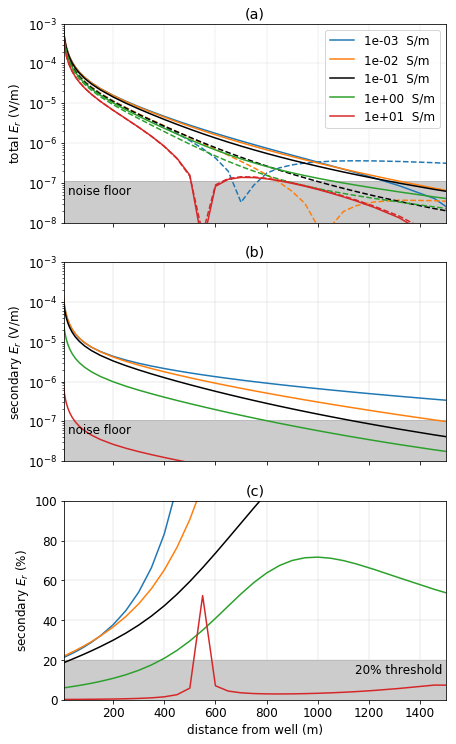

In [68]:
fig, ax = plt.subplots(3, 1, figsize = (6.5, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 0
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 100]
theta_ind = 4

noise_floor = 1e-7
min_percent = 20

eps = 1e-8

unit = " S/m"

for i, sigma, color_ind in zip(range(len(conductivities)), conductivities, [0, 1, 0, 2, 3]): 
    
    key = "flaw_{}".format(sigma if sigma < 1 else int(sigma))
    baseline_key = "baseline_{}".format(sigma if sigma < 1 else int(sigma))
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict[baseline_key].survey.srcList[src_ind]
    label="{:1.0e} {}".format(float(sigma), unit)

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=color_ind if sigma != sigma_back else None, 
        color="k" if sigma == sigma_back else None
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(fieldsDict[baseline_key][baseline_src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind, 
        color_ind=color_ind if sigma != sigma_back else None, 
        color="k" if sigma == sigma_back else None, linestyle="--"
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, 
        label=label, color_ind=color_ind if sigma != sigma_back else None,
        color="k" if sigma == sigma_back else None
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
            (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+eps)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, 
        label=label, color_ind=color_ind if sigma != sigma_back else None,
        color="k" if sigma == sigma_back else None
    )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    if i == 0:
        a.legend(loc=1)
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")        
plt.tight_layout()

fig.savefig('integrity_layer', bbox_inches="tight", dpi=350)

In [71]:
model = modelDict[model_names[0]]

def conduction_length(sigma_c):
    return np.sqrt(4 * np.pi * model.casing_a * model.casing_t * sigma_c / sigma_back)

In [72]:
[conduction_length(sig) for sig in [5e5, 5e6, 5e7]]

[158.53309190424045, 501.3256549262001, 1585.3309190424045]